In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import NCP
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, multivariate_normal

# Example symmetric conditional expectation and density estimation


This toy examples studies the problem of conditional density estimation and conditional expectation in the presence of symmetries in the marginals and in the joint probability distributions


In [4]:
def marginal_x(means, covariances, weights):
    """
    Creates a Gaussian mixture distribution in R. With reflectional symmetry.
    That is p(x) = p(-x).

    Args:
        means (list of float): Means of the Gaussian components.
        covariances (list of float): Variances of the Gaussian components.
        weights (list of float): Weights of the Gaussian components.

    Returns:
        function: A function that computes the PDF and samples from the mixture.
    """
    # TODO: symmetrize.
    components = [norm(loc=mean, scale=np.sqrt(cov)) for mean, cov in zip(means, covariances)]

    def pdf(x):  # Marginal PDF
        return sum(weight * component.pdf(x) for weight, component in zip(weights, components))

    def sample(size):
        component_choices = np.random.choice(len(weights), size=size, p=weights)
        samples = [components[i].rvs() for i in component_choices]
        return np.asarray(samples)

    assert np.isclose(pdf(-1), pdf(1)), f"p(1)={pdf(-1)}!=p(-1)={pdf(1)}"

    return pdf, sample

def marginal_y(pdf_x):
    """
    Creates a conditional distribution p(y|x) = p(x) / |dy/dx|.
    Where y = 0.5 * x^3. And if p(x) posses C2 symmetry, then p(y) will also possess C2 symmetry.

    Args:
        pdf_x (function): The marginal PDF p(x).

    Returns:
        pdf_y, y_sampler: The conditional PDF p(y|x) and a sampler for y.
    """
    def transport_fn(x):
        return 0.5 * x**3

    def pdf(y): # Marginal PDF.
        # Inverse of the transport function
        x_inv = (2 * y) ** (1/3)
        return pdf_x(x_inv) / np.abs(1.5 * x_inv**2)

    def cond_pdf(x) -> callable([float], float):
        """ return the conditional pdf p(y|x) as a callable accepting x """

    return pdf, transport_fn

# Example setup: Gaussian mixture with reflectional symmetry
means = [-4, 0, 4]
covariances = [0.4, 0.2, 0.4]
weights = [0.3, 0.1, 0.3]
weights /= np.sum(weights)

x_pdf, x_sampler = marginal_x(means, covariances, weights)
x_samples = x_sampler(5000)
y_pdf, transport_fn = marginal_y(x_pdf)
y_samples = transport_fn(x_samples)
x_range = (np.min(x_samples), np.max(x_samples))
y_range = (np.min(y_samples), np.max(y_samples))

TypeError: callable() takes exactly one argument (2 given)

<Figure size 1000x800 with 0 Axes>

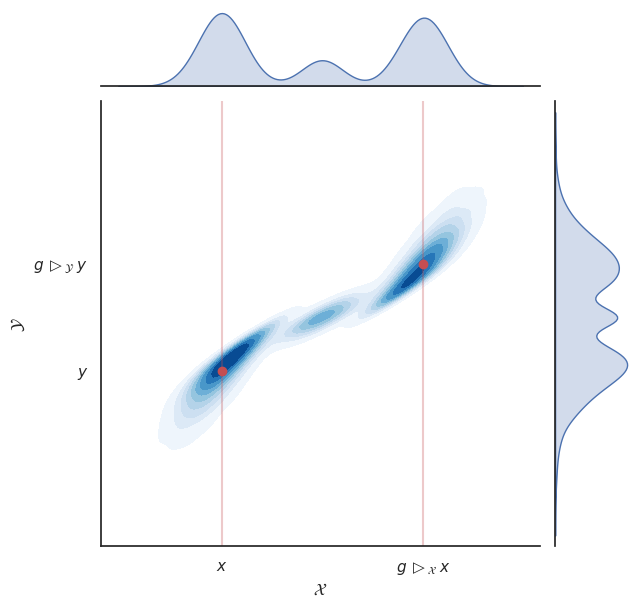

In [92]:
# Plotting the results
sns.set(style="white")

# Create a figure with joint 2D and marginal plots
fig = plt.figure(figsize=(10, 8))
grid = sns.JointGrid()
# Joint KDE plot
sns.kdeplot(x=x_samples, y=y_samples, fill=True, ax=grid.ax_joint, cmap="Blues")
# Marginal of p(x)
x_vals = np.linspace(min(x_samples), max(y_samples), 500)
x_pdf_vals = x_pdf(x_vals)
# Marginal of p(y) -- KDE for Y with symmetry adjustment
sns.kdeplot(x=x_samples, ax=grid.ax_marg_x, fill=True)
sns.kdeplot(y=y_samples, ax=grid.ax_marg_y, fill=True)
# Plot the point x=(-4,4) and y(transport_fn(-4), transport_fn(4))
x_test = 4
grid.ax_joint.plot([-x_test, x_test], [transport_fn(-x_test), transport_fn(x_test)], 'ro')
# draw slightly transparent vertical lines at x_test and -x_test
grid.ax_joint.axvline(x_test, color='r', alpha=0.3)
grid.ax_joint.axvline(-x_test, color='r', alpha=0.3)

# Set x ticks only to the test points with labels
grid.ax_joint.set_xticks([-x_test, x_test])
grid.ax_joint.set_xticklabels([r"$x$", r"$g \;\triangleright_{\mathcal{X}}\; x$"])
# Set y ticks only to the test points with labels
grid.ax_joint.set_yticks([transport_fn(-x_test), transport_fn(x_test)])
grid.ax_joint.set_yticklabels([r"$y$", r"$g \;\triangleright_{\mathcal{Y}}\; y$"])

# Customizing labels
grid.ax_joint.set_xlabel(r"$\mathcal{X}$")
grid.ax_joint.set_ylabel(r"$\mathcal{Y}$")
grid.ax_marg_x.set_xlabel(r"$p(\textnormal{x})$")
grid.ax_marg_y.set_ylabel(r"$p(\textnormal{y})$")

plt.show()